## Naive Bayes Classifier - Text Classification - Multinomial & Bernoulli

In this notebook you will apply the Naive Bayes algorithms for text classification.

Your tasks are marked with task numbers (e.g., Task 1). To get full credit you need to complete **ALL** tasks.



### Dataset: The 20 Newsgroups data set


The 20 newsgroups dataset comprises around 20,000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The 20 newsgroups collection has become a popular data set for experiments in text applications of machine learning techniques, such as text classification and text clustering. The split between the train and test set is based upon a messages posted before and after a specific date.

Following is a list of the 20 newsgroups, partitioned (more or less) according to subject matter:

- alt.atheism
- comp.graphics
- comp.os.ms-windows.misc
- comp.sys.ibm.pc.hardware
- comp.sys.mac.hardware
- comp.windows.x
- misc.forsale
- rec.autos
- rec.motorcycles
- rec.sport.baseball
- rec.sport.hockey
- sci.crypt
- sci.electronics
- sci.med
- sci.space
- soc.religion.christian
- talk.politics.guns
- talk.politics.mideast
- talk.politics.misc
- talk.religion.misc


You will normalize the documents, perform preprocessing and vectorize the features. Since the features are categorical, you will implement two different naive Bayes classifiers using Scikit-Learn. 
- Categorical features (binary valued) are modeled using the Multivariate Bernoulli distrubition 
- Categorical features (multi-valued) are modeled using the Multinomial distrubition 


## Steps for Classification:

1. Exploratory Data Analysis
2. Feature Extraction
   - a. Text Normalization (Stemming & Lemmatization)
   - b. Text Preprocessing (Tokenization, removing stop words, etc.)
   - c. Vectorization of the features
3. Model Selection by Hyperparameter Tuning
4. Train the Optimal Model
5. Analyzing Model Performance
6. Evaluate the Model on Test Data

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

import nltk
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

from sklearn.datasets import fetch_20newsgroups

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\megha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Load Data

You will work on a partial dataset with only 4 categories out of the 20 available in the dataset:
- alt.atheism
- soc.religion.christian
- comp.graphics
- sci.med


The samples are shuffled randomly. This is useful if you wish to select only a subset of samples to quickly train a model and get a first idea of the results before re-training on the complete dataset later.

## Create Train and Test Sets 

In [20]:
categories = ['alt.atheism', 'soc.religion.christian','comp.graphics', 'sci.med']

train_data = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
X_train = train_data.data
y_train = train_data.target


test_data = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)
X_test = test_data.data
y_test = test_data.target

# <font color=blue> 1. Exploratory Data Analysis</font>

## Quick Check of the Data

In [3]:
print("Target Names: ", train_data.target_names)

print("\nNumber of Training Examples: ", len(X_train))
print("Number of Training Labels: ", len(y_train))

print("Number of Test Examples: ",len(X_test))
print("Number of Test Labels: ", len(y_test))


print("\nPrint a Random Document:\n")
print(X_train[0])
#print(y_train[2])

Target Names:  ['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']

Number of Training Examples:  2257
Number of Training Labels:  2257
Number of Test Examples:  1502
Number of Test Labels:  1502

Print a Random Document:

From: sd345@city.ac.uk (Michael Collier)
Subject: Converting images to HP LaserJet III?
Nntp-Posting-Host: hampton
Organization: The City University
Lines: 14

Does anyone know of a good way (standard PC application/PD utility) to
convert tif/img/tga files into LaserJet III format.  We would also like to
do the same, converting to HPGL (HP plotter) files.

Please email any response.

Is this the correct group?

Thanks in advance.  Michael.
-- 
Michael Collier (Programmer)                 The Computer Unit,
Email: M.P.Collier@uk.ac.city                The City University,
Tel: 071 477-8000 x3769                      London,
Fax: 071 477-8565                            EC1V 0HB.



## Class Distribution

#### Task 1: Compute class distribution in the following block (5 pts)

In [21]:


for i in range(len(X_train)):
    X_train[i] = (X_train[i],)
df = pd.DataFrame.from_records(X_train, columns = ['text'])
#df.info()
df.head()
df['cls'] = y_train
df.head()
    

,text,cls
0,From: sd345@city.ac.uk (Michael Collier)\nSubj...,1
1,From: ani@ms.uky.edu (Aniruddha B. Deglurkar)\...,1
2,From: djohnson@cs.ucsd.edu (Darin Johnson)\nSu...,3
3,From: s0612596@let.rug.nl (M.M. Zwart)\nSubjec...,3
4,From: stanly@grok11.columbiasc.ncr.com (stanly...,3


In [5]:
df.groupby('cls').count()

,text
cls,
0,480
1,584
2,594
3,599


## Visualization of the Class Distribution


#### Task 2: Generate visualization of the class distribution in the following block (5 pts)

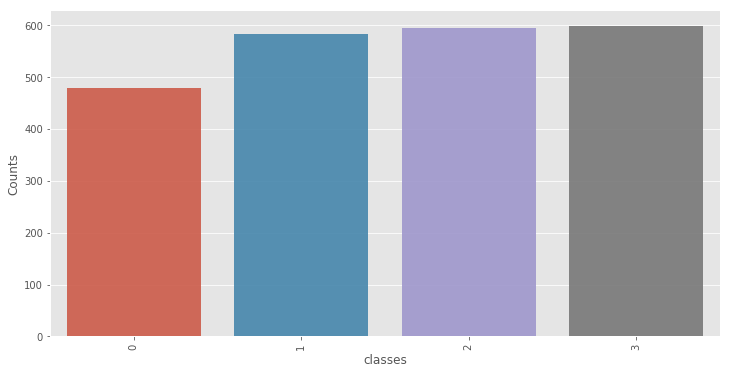

In [6]:
label_counts = df.cls.value_counts()
plt.figure(figsize = (12,6))
sns.barplot(label_counts.index, label_counts.values, alpha = 0.9)

plt.xticks(rotation = 'vertical')
plt.xlabel('classes', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()

# <font color=blue> 2. Feature Extraction </font>

## a) Text Normalization by Lemmatization

Stemming and Lemmatization are Text Normalization (or sometimes called Word Normalization) techniques in the field of Natural Language Processing that are used to prepare text, words, and documents for further processing.


#### Task 3: Lemmatize the training data. You may stem it as well, if it improves the classification accuracy. (10 pts)

In [25]:
#nltk.download()
#%%time
lemmatizer = WordNetLemmatizer()

df['text_lemmatized'] = df['text'].map(lambda text: ' '.join(lemmatizer.lemmatize(w) for w in nltk.word_tokenize(text.lower())))

In [26]:
print(df['text'][171])
print("\nLemmatized Email:\n")
print(df['text_lemmatized'][171])

From: mdw33310@uxa.cso.uiuc.edu (Michael D. Walker)
Subject: Re: Question about Virgin Mary
Organization: University of Illinois at Urbana
Lines: 58

a.faris@trl.oz.au (Aziz Faris) writes:

>Helllo Netters:

>I was told the Bible says that God took the body of the Virgin Mary as
>she was being carried for burial. Is this true, if so were in the Bible
>does it say that.

>Regards,
>A.Faris

>[I think you're talking about the "assumption of the Blessed Virgin
>Mary".  It says that "The Immaculate Mother of God, the ever Virgin
>Mary, having completed the course of her earthly life, was assumed
>body and soul into heavenly glory."  This was defined by a Papal
>statement in 1950, though it had certainly been believed by some
>before that.  Like the Immaculate Conception, this is primarily a
>Roman Catholic doctrine, and like it, it has no direct Biblical
>support.  Note that Catholics do not believe in "sola scriptura".
>That is, they do not believe that the Bible is the only source of
>Ch

# <font color=blue> 2. Feature Extraction </font>

## b) Text Preprocessing & c) Feature Vectorization

We can combine text preprocessing, feature vectorization and model training using the sklearn Pipeline object. This Pipeline object can be used for model selection and for training the optimal model. 

## <font color=blue> 3. Model Selection </font>


There are no hyperparameters in a NB model except the Laplace smoothing parameter alpha.

However, there are multiple hyperparameters for the CountVectorizer() and TfidfTransformer(). We need to select the best model based on the optimal values of these hyperparameters. This process is called hyper-parameter tuning.

For hyperparameter tuning, we will build a compund classifier using the sklearn Pipeline class. It will combine the CountVectorizer(), TfidfTransformer() and MultinomialNB() objects and will create a single object.

## Building a Pipeline for Hyperparameter Tuning


#### Task 4: Build a Pipeline object by combining CountVectorizer() and MultinomialNB() (5 pts)

In [27]:
text_clf_multinomialNB = Pipeline([
        ('vect', CountVectorizer()),
#         ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB()),
    ])

## Hyperparameter Tuning

#### Task 5: Perform hyperparamer tuning for the following hyperparameters: (5 pts)
- CountVectorizer()
         -- ngram_range
         -- stop_words
- MultinomialNB()
        -- alpha
        
## **<font color=red size=5>Important:</font>**

The GridSearchCV takes an argument to define the scoring metric (performance measure). 

See the list of possible scoring functions:
https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

For multiclass classification, we may use "f1_micro" scoring function. The f1_micro function is the average of the F1 score of each class with weighting depending on the average parameter.

The macro-average ("f1_macro") will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average ("f1_micro") will aggregate the contributions of all classes to compute the average metric. In a multi-class classification setup, micro-average is preferable if you suspect there might be class imbalance (i.e you may have many more examples of one class than of other classes).

In the binary classification, "f1" score function can be used. We may also use the precision_score, recall_score, roc_auc_score functions.

In [49]:
#%%time
param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__stop_words': ['english', None],
#    'vect__binary': [True, False],
    'clf__alpha': [0.1, 1.0, 1.5, 1.8]
#     'tfidf__use_idf': (True, False),
#     'tfidf__norm': ('l1', 'l2'),
}

clf_multinomial_cv = GridSearchCV(text_clf_multinomialNB, param_grid, scoring='f1_micro', cv=5)

clf_multinomial_cv = clf_multinomial_cv.fit(df.text_lemmatized, y_train)


print("\nBest Score: %f" % clf_multinomial_cv.best_score_)

print("\nOptimal Hyperparameter Values: ")

for param_name in sorted(param_grid.keys()):
    print("%s: %r" % (param_name, clf_multinomial_cv.best_params_[param_name]))



Best Score: 0.980505

Optimal Hyperparameter Values: 
clf__alpha: 0.1
vect__ngram_range: (1, 2)
vect__stop_words: 'english'


# <font color=blue> 4. Train the Optimal Multinomial Model </font>

#### Task 6: Using the optimal hyperparameter values, create the optimal model. Then, fit the model. (10 pts)
- Build a Pipeline object by combining CountVectorizer() and MultinomialNB()

In [60]:
multinomialNB_clf = Pipeline([
        ('vect', CountVectorizer(stop_words='english', ngram_range=(1, 2), binary=False)),
        ('clf', MultinomialNB(alpha=0.1)),
    ])


multinomialNB_clf.fit(df.text_lemmatized, y_train)


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('clf', MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True))])

# <font color=blue> 6. Evaluate the Model on Test Data </font>

#### Task 7:  Evaluate the model on test data and generate (10 pts)
- Confusion Matrix
- Precision
- Recall
- F1 score
- Classification Report


### Note: For multi-class classification, set the "average" attribute to "micro" for the following functions:
- precision_score
- recall_score
- f1_score

In [61]:
y_test_predicted = multinomialNB_clf.predict(X_test)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


precision_test = precision_score(y_test, y_test_predicted, average= "micro") 
print("\nTest Precision = %f" % precision_test)


recall_test = recall_score(y_test, y_test_predicted, average= "micro")
print("Test Recall = %f" % recall_test)


f1_test = f1_score(y_test, y_test_predicted, average= "micro")
print("Test F1 Score = %f" % f1_test)



print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']))



Test Confusion Matrix:
[[298   4   5  12]
 [  6 376   5   2]
 [  7  23 358   8]
 [  5   4   4 385]]

Test Precision = 0.943409
Test Recall = 0.943409
Test F1 Score = 0.943409

Classification Report:
                        precision    recall  f1-score   support

           alt.atheism       0.94      0.93      0.94       319
         comp.graphics       0.92      0.97      0.94       389
               sci.med       0.96      0.90      0.93       396
soc.religion.christian       0.95      0.97      0.96       398

             micro avg       0.94      0.94      0.94      1502
             macro avg       0.94      0.94      0.94      1502
          weighted avg       0.94      0.94      0.94      1502



#  Multinomial NB: TF-IDF Model

#### Task 8: Implement the Multinomial model using the TF-IDF feature vectors (10 pts)
- Build a Pipeline object by combining CountVectorizer(), TfidfTransformer() and MultinomialNB()

In [62]:
multinomialNB_clf_tfidf = Pipeline([
        ('vect', CountVectorizer(stop_words='english', ngram_range=(1, 1), binary=False)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB(alpha=0.1)),
    ])


multinomialNB_clf_tfidf.fit(df.text_lemmatized, df.cls)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        ...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True))])

## Evaluate the Model on Test Data 

#### Task 9: Evaluate the model on test data and generate (10 pts)
- Confusion Matrix
- Precision
- Recall
- F1 score
- Classification Report

In [63]:
y_test_predicted = multinomialNB_clf_tfidf.predict(X_test)



print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


precision_test = precision_score(y_test, y_test_predicted, average = "micro") 
print("\nTest Precision = %f" % precision_test)


recall_test = recall_score(y_test, y_test_predicted, average = "micro")
print("Test Recall = %f" % recall_test)


f1_test = f1_score(y_test, y_test_predicted, average = "micro")
print("Test F1 Score = %f" % f1_test)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']))


Test Confusion Matrix:
[[277   3   8  31]
 [  5 377   1   6]
 [  4  20 359  13]
 [  4   3   3 388]]

Test Precision = 0.932756
Test Recall = 0.932756
Test F1 Score = 0.932756

Classification Report:
                        precision    recall  f1-score   support

           alt.atheism       0.96      0.87      0.91       319
         comp.graphics       0.94      0.97      0.95       389
               sci.med       0.97      0.91      0.94       396
soc.religion.christian       0.89      0.97      0.93       398

             micro avg       0.93      0.93      0.93      1502
             macro avg       0.94      0.93      0.93      1502
          weighted avg       0.93      0.93      0.93      1502



## <font color=maroon> Observation on Multinomial Model With TF-IDF Feature Vectors </font>

We observe that both precision and recall decrease with TF-IDF feature vectors. 

#  Multivariate Bernoulli NB

#### Task 10: Implement the Multivariate Bernoulli Model (10 pts)
- Build a Pipeline object by combining CountVectorizer() and BernoulliNB()

### <font color=red> Note: </font>
The "binary" attribute of the CountVectorizer() object should be set to "True".

In [45]:
bernoulliNB_clf = Pipeline([
        ('vect', CountVectorizer(stop_words='english', ngram_range=(1, 1), binary=True)),
        ('clf', BernoulliNB(alpha=0.1)),
    ])

bernoulliNB_clf.fit(df.text_lemmatized, df.cls)



Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('clf', BernoulliNB(alpha=0.1, binarize=0.0, class_prior=None, fit_prior=True))])

## Evaluate the Model on Test Data 


#### Task 11: Evaluate the model on test data and generate (10 pts)
- Confusion Matrix
- Precision
- Recall
- F1 score
- Classification Report

In [47]:
y_test_predicted = bernoulliNB_clf.predict(X_test)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


precision_test = precision_score(y_test, y_test_predicted, average = "micro") 
print("\nTest Precision = %f" % precision_test)


recall_test = recall_score(y_test, y_test_predicted, average = "micro")
print("Test Recall = %f" % recall_test)


f1_test = f1_score(y_test, y_test_predicted, average = "micro")
print("Test F1 Score = %f" % f1_test)

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']))


Test Confusion Matrix:
[[286  12   7  14]
 [  6 381   2   0]
 [  4  83 308   1]
 [  5  36   2 355]]

Test Precision = 0.885486
Test Recall = 0.885486
Test F1 Score = 0.885486

Classification Report:
                        precision    recall  f1-score   support

           alt.atheism       0.95      0.90      0.92       319
         comp.graphics       0.74      0.98      0.85       389
               sci.med       0.97      0.78      0.86       396
soc.religion.christian       0.96      0.89      0.92       398

             micro avg       0.89      0.89      0.89      1502
             macro avg       0.90      0.89      0.89      1502
          weighted avg       0.90      0.89      0.89      1502



## <font color=maroon> Observation on Multivariate Bernoulli Model </font>

#### Task 12: Write a short account of your observation on the following aspects of your experimentation with 3 NB classifiers (10 pts):
- Impact of data normalization technique (did you observe performance improvement with lemmatization and/or stemming)
Interestingly, the best score value while doing hyperparameter tuning is better for normal text than the lemmatized text. Also, in the first model multinomialNB_clf, both lemmatized and normal text had the same values for precision, recall and F1 score. However, when the Multinomial NB: TF-IDF Model is used, lemmatized text showed a better performance than the normal text.
- Which classifier gave the best precision? Best recall? Best F1 Score? Explain their performance variance.
Multinomial NB gave the best values. Precision : 0.943409, Recall : 0.943409, F1 Score : 0.943409
